<a href="https://colab.research.google.com/github/sakuronohana/cas_datenanalyse/blob/master/Semesterarbeit/CAS_DA_SA_Payment_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img 
src="https://www.ffhs.ch/templates/ffhs/img/logo@2x.png" width="100"> 
###DaAn, Data Analysis, MAS/CAS Web4B 2018, ZH1, FS19, Dr. Tödtli Beat###

##*Semesterarbeit von Patrik Di Lena*##
#Betrugserkennung Zahlungsverkehr#



##Ziel##
Das Ziel dieser Semesterarbeit ist die Gegenüberstellung von Supervised und Unsupervised Lernverfahren mit Hilfe neuronaler Netzwerk Algorithmen. Dabei kommt  ein nicht gelabelter und ein gelabelter Datensatz aus einem Betrugserkennungssystem zum Einsatz. 

##Aufgabenstellung##
###Erkennung von Betrugszahlungen###
Mittels Unsupervised Learning sollen Betrugszahlungen aus einem nicht gelabelten Datensatz erkannt und die Effiktivität des vorhandenen Fraud-Detection Systems geprüft werden. In diesem Fall wird ein Autoencoder Neural Network mit Tensorflow aufgebaut. 

###Betrugsanfällige Risikogruppen###
Mit Hilfe von Supervised Learning werden mögliche Risikogruppen ermittelt, welche im Visier von Betrügern stehen.  Auf Basis eines gelabelten Datensatzes  werden die Risikogruppen nach folgenden Merkmalen unterschieden:

*	Geschlecht
*	Alter
*	Zivilstand
*	Nationalität
*	Kontosaldo
*	Wohnort
*	Region

In diesem Fall wird der Deep Learning Algorithmus Convlutional Neural Network zum Einsatz kommen.

##Datensatz##
Die im Rahmen dieser Semesterarbeit verwendeten Daten entstammen, von ihrer Datenstruktur her, aus einem bereits eingesetzten nicht ML-basierten Betrugserkennungssystem. Die Datenwerte wurde zu Wahrung der datenschutzrechtlichen und bankengesetzlichen Aspekte mit Hilfe eines Python-Scripts künstlich erzeugt und beinhalten somit keine reale Zahlungs- oder Kunden-Informationen.   

Datenselektion:

- 20'800 synthetische Kunden (Vorname, Name, Strasse, Ort, Kanton, Sprachregion, Geschlecht, Alter, Zivilstand,  Nationalität, Kontonummer, Vertragsnummer, Rechtsform)

- 60'000 synthetische Zahlungen (Transaktionsid, ,Erstellungdatum/Zeit, Empfängerkonto, Empfängerbank, Empfängerland, Währung, Betrag, Valuta Datum)








#Vorbereitungen# 


In [1]:
# import packages

import pandas as pd
import numpy as np
from scipy import stats
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.preprocessing import StandardScaler
from pylab import rcParams
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
%matplotlib inline



Using TensorFlow backend.


In [2]:
# Laden der 600000 Transaktionsdaten 
trx_data_url = 'https://raw.githubusercontent.com/sakuronohana/cas_datenanalyse/master/Semesterarbeit/Dataset/trx_data_ml.csv'
trx_data = pd.read_csv(trx_data_url, delimiter=';')

print (trx_data.shape)
trx_data.head()

(60000, 20)


,timestamp,paym_id,send_bc_nr,amount,rcv_bc_nr,rcv_bc_iban,rcv_bc_country,rcv_bc_code,rcv_iban,valuta_date,cust_vertrag_nr,cust_konto_nr,cust_vname,cust_nname,cust_plz,cust_ort,cust_kanton,cust_sprachregion,cust_auth_device,fraud_id
0,01.01.18 08:00,10000010,CHBANK71XXX,15368,JOBANK40XXX,JO02SCBL1260000000018525836101,Jordanien,JO,JO40002096331755419,01.01.18 08:00,76311,CH5300772672529640195,Martin,Bader,6020,Emmenbrücke,LU,de,mtan,0
1,01.01.18 08:00,10000011,CHBANK71XXX,89137,STBANK68XXX,ST23000200000289355710148,Sao Tome und Principe,ST,ST68002492808312214,01.01.18 20:00,69891,CH5300772670061796126,Margaretha,Fehr,9056,Gais,AR,de,ptan,0
2,01.01.18 08:01,10000012,CHBANK71XXX,87673,XKBANK43XXX,XK051301001002074155,Kosovo,XK,XK43002422391264290,02.01.18 08:01,78573,CH5300772500037725234,Daniel,Miéville,1253,Vandoeuvres,GE,fr,ptan,0
3,01.01.18 08:01,10000013,CHBANK71XXX,55941,RSBANK72XXX,RS35105008054113238018,Serbien,RS,RS72002873180573624,02.01.18 20:01,75443,CH5300772732508635138,Andrea,Iseni,6026,Rain,LU,de,mtan,0
4,01.01.18 08:02,10000014,CHBANK71XXX,88173,LIBANK48XXX,LI0308800000022875748,Liechtenstein,LI,LI48002899580343897,03.01.18 08:02,73167,CH5300772640237288398,Andrea,Pinana,6693,Broglio,TI,it,mtan,0


###Reduktion des Datensatzes###

Der Datensatz wird auf 10000 Daten reduziert, da die für die Semesterarbeit zur Verfügung stehende Infrastruktur über zuwenig Kapazitäten verfügt um die intensiven Rechenoperationen (Encoding, PCA, NN Training) durchzuführen.


In [3]:
# Reduktion des Datensatzes auf 10000 

trx_data = trx_data.sample(frac=0.34)
trx_data.shape

(20400, 20)

In [4]:
# Verhältnis zwischen Gesamtdatensatz und Fraud-Daten prüfen
# Fraud-Zahlungen haben Wert 1 (Label = fraud_id)

pd.value_counts(trx_data['fraud_id'], sort = True)

0    19517
1      883
Name: fraud_id, dtype: int64

In [5]:
# Kleine Bereinigungsarbeiten

# Erstellung von Datensatz mit benötigen Merkmalen

features = ['send_bc_nr','amount','rcv_bc_nr', 
            'rcv_bc_iban','rcv_bc_country','rcv_bc_code','rcv_iban',
            'valuta_date','cust_vertrag_nr','cust_konto_nr','cust_plz','cust_ort',
            'cust_kanton','cust_sprachregion','cust_auth_device','fraud_id'] 

trx_data = pd.DataFrame((trx_data.loc[:, features].values),columns=[features])

# Umwandlung von offensichtlichen nummerische werten in Integers
#trx_data['amount'] = trx_data['amount'].convert_objects(convert_numeric=True)
#trx_data['cust_vertrag_nr'] = trx_data['cust_vertrag_nr'].convert_objects(convert_numeric=True)
#trx_data['cust_plz'] = trx_data['cust_plz'].convert_objects(convert_numeric=True)

#Suche des Datensatzes nach Null-Werten
trx_data.isnull().values.sum()

print(trx_data.dtypes)
trx_data.head()

send_bc_nr           object
amount               object
rcv_bc_nr            object
rcv_bc_iban          object
rcv_bc_country       object
rcv_bc_code          object
rcv_iban             object
valuta_date          object
cust_vertrag_nr      object
cust_konto_nr        object
cust_plz             object
cust_ort             object
cust_kanton          object
cust_sprachregion    object
cust_auth_device     object
fraud_id             object
dtype: object


,send_bc_nr,amount,rcv_bc_nr,rcv_bc_iban,rcv_bc_country,rcv_bc_code,rcv_iban,valuta_date,cust_vertrag_nr,cust_konto_nr,cust_plz,cust_ort,cust_kanton,cust_sprachregion,cust_auth_device,fraud_id
0,CHBANK71XXX,48671,GLBANK32XXX,GL2664710001504964,Grönland,GL,GL32002613168342195,21.02.60 00:20,66924,CH5300772486098109628,6105,Schachen LU,LU,de,mtan,1
1,CHBANK71XXX,17857,AEBANK83XXX,AE020090004001079346500,Vereinigte Arabische Emirate,AE,AE83002878995200146,23.07.52 02:13,80106,CH5300772632872145624,6102,Malters,LU,de,ptan,0
2,CHBANK71XXX,93206,PKBANK61XXX,PK02SCBL0000001925518401,Pakistan,PK,PK61002589491451064,08.07.20 23:19,74928,CH5300772590456720155,6234,Triengen,LU,de,mtan,0
3,CHBANK71XXX,37027,CZBANK79XXX,CZ0201000000199216760237,Tschechien,CZ,CZ79002097367856088,14.04.77 20:38,69760,CH5300772157447219770,3185,Schmitten FR,FR,de,ptan,0
4,CHBANK71XXX,14946,PSBANK62XXX,PS06ARAB000000009040781605610,Palästina,PS,PS62002185047371497,19.04.86 03:27,79737,CH5300772990903293339,6110,Wolhusen,LU,de,mtan,0


In [6]:
# Erstellung Datensatz mit Label für Supervised Learning wobei

tdm = trx_data

print (tdm.shape)
tdm.head()

(20400, 16)


,send_bc_nr,amount,rcv_bc_nr,rcv_bc_iban,rcv_bc_country,rcv_bc_code,rcv_iban,valuta_date,cust_vertrag_nr,cust_konto_nr,cust_plz,cust_ort,cust_kanton,cust_sprachregion,cust_auth_device,fraud_id
0,CHBANK71XXX,48671,GLBANK32XXX,GL2664710001504964,Grönland,GL,GL32002613168342195,21.02.60 00:20,66924,CH5300772486098109628,6105,Schachen LU,LU,de,mtan,1
1,CHBANK71XXX,17857,AEBANK83XXX,AE020090004001079346500,Vereinigte Arabische Emirate,AE,AE83002878995200146,23.07.52 02:13,80106,CH5300772632872145624,6102,Malters,LU,de,ptan,0
2,CHBANK71XXX,93206,PKBANK61XXX,PK02SCBL0000001925518401,Pakistan,PK,PK61002589491451064,08.07.20 23:19,74928,CH5300772590456720155,6234,Triengen,LU,de,mtan,0
3,CHBANK71XXX,37027,CZBANK79XXX,CZ0201000000199216760237,Tschechien,CZ,CZ79002097367856088,14.04.77 20:38,69760,CH5300772157447219770,3185,Schmitten FR,FR,de,ptan,0
4,CHBANK71XXX,14946,PSBANK62XXX,PS06ARAB000000009040781605610,Palästina,PS,PS62002185047371497,19.04.86 03:27,79737,CH5300772990903293339,6110,Wolhusen,LU,de,mtan,0


In [7]:
# Erstellung Datensatz ohne Label (fraud_id) für Unsupervised Learning

features = ['send_bc_nr','amount','rcv_bc_nr', 
            'rcv_bc_iban','rcv_bc_country','rcv_bc_code','rcv_iban',
            'valuta_date','cust_vertrag_nr','cust_konto_nr','cust_plz','cust_ort',
            'cust_kanton','cust_sprachregion','cust_auth_device'] 

tdo = pd.DataFrame((trx_data.loc[:, features].values),columns=[features])

# Umwandlung von offensichtlichen nummerische werten in Integers
#tdo['amount'] = tdo['amount'].convert_objects(convert_numeric=True)
#tdo['cust_vertrag_nr'] = tdo['cust_vertrag_nr'].convert_objects(convert_numeric=True)
#tdo['cust_plz'] = tdo['cust_plz'].convert_objects(convert_numeric=True)

print (tdo.shape)
print (tdo.dtypes)
tdo.head()



(20400, 15)
send_bc_nr           object
amount               object
rcv_bc_nr            object
rcv_bc_iban          object
rcv_bc_country       object
rcv_bc_code          object
rcv_iban             object
valuta_date          object
cust_vertrag_nr      object
cust_konto_nr        object
cust_plz             object
cust_ort             object
cust_kanton          object
cust_sprachregion    object
cust_auth_device     object
dtype: object


,send_bc_nr,amount,rcv_bc_nr,rcv_bc_iban,rcv_bc_country,rcv_bc_code,rcv_iban,valuta_date,cust_vertrag_nr,cust_konto_nr,cust_plz,cust_ort,cust_kanton,cust_sprachregion,cust_auth_device
0,CHBANK71XXX,48671,GLBANK32XXX,GL2664710001504964,Grönland,GL,GL32002613168342195,21.02.60 00:20,66924,CH5300772486098109628,6105,Schachen LU,LU,de,mtan
1,CHBANK71XXX,17857,AEBANK83XXX,AE020090004001079346500,Vereinigte Arabische Emirate,AE,AE83002878995200146,23.07.52 02:13,80106,CH5300772632872145624,6102,Malters,LU,de,ptan
2,CHBANK71XXX,93206,PKBANK61XXX,PK02SCBL0000001925518401,Pakistan,PK,PK61002589491451064,08.07.20 23:19,74928,CH5300772590456720155,6234,Triengen,LU,de,mtan
3,CHBANK71XXX,37027,CZBANK79XXX,CZ0201000000199216760237,Tschechien,CZ,CZ79002097367856088,14.04.77 20:38,69760,CH5300772157447219770,3185,Schmitten FR,FR,de,ptan
4,CHBANK71XXX,14946,PSBANK62XXX,PS06ARAB000000009040781605610,Palästina,PS,PS62002185047371497,19.04.86 03:27,79737,CH5300772990903293339,6110,Wolhusen,LU,de,mtan


In [0]:
tdo.dropna(inplace=True)

##Vorbereitung für Datenverarbeitung ##

###Encoding der Daten###

Die importierten Daten werden als Object bzw. kategorische Daten ausgewiesen. Damit die Daten im Maschine Learning verwendet werden können müssen sie in nummerische Daten umgewandelt werden. Was natürlch nicht so ganz einfach ist wie es sich anhört, da eine hohe Anzahl von kategorischen Werten in einem Datensatz bei der Encodierung zu einer Vervielfachung der Features führt. 
Hat Beispielsweise eine Features 300 verschiedene Werte, dann entstehen bei der Encodierung auch 300 Features (Spalten).

In [0]:
# Encoding mittels Get_Dummies von Pandas.
tdoe = pd.get_dummies(tdo, columns=['send_bc_nr','rcv_bc_nr', 
            'rcv_bc_iban','rcv_bc_country','rcv_bc_code','rcv_iban',
            'valuta_date','cust_konto_nr','cust_ort',
            'cust_kanton','cust_sprachregion','cust_auth_device'],drop_first=True)
                            


tdoe.head()

**Datensatz in Trainings- und Testingdatensatz aufteilen 80/20**

Trainingsdatensatz  = 16320
Testdatensatz = 4080

In [44]:
from sklearn.model_selection import train_test_split
tdoe_train, tdoe_test = train_test_split(tdoe,test_size=0.2, random_state = 70)

print ('Grösse Trainingsdatesatz (Shape) = ', tdoe_train.shape)
print ('Grösse Testdatensatz (Shape) =', tdoe_test.shape)

Grösse Trainingsdatesatz (Shape) =  (16320, 56132)
Grösse Testdatensatz (Shape) = (4080, 56132)


###Standardisierung der Daten###

Zur optimalen Verwendung der Daten für ein Neuronales Netzwerk werden die Daten in ein einheitliches Format gebracht.

In [46]:
tdoe_train = StandardScaler().fit_transform(tdoe_train.values.reshape(-1, 1))
tdoe_test = StandardScaler().fit_transform(tdoe_test.values.reshape(-1, 1))

/Users/dili/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/dili/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/dili/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/dili/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [0]:
from sklearn.decomposition import PCA

pca = PCA(.95)



In [53]:
pca.fit(tdoe_train,tdoe_test)


PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [0]:
tdoesp_train = pca.transform(tdoe_train)
tdoesp_test = pca.transform(tdoe_test)

In [55]:
print (tdoesp_train.shape)
print (tdoesp_test.shape)

(916074240, 1)
(229018560, 1)


#Erkennung von Betrugszahlungen# 

##Unsupervised Learning mit neuronalen Netzwerken##

**Datensatz in Trainings- und Testingdatensatz aufteilen**

Da wir über einen relative grosses Datenset verfügen können wir eine klassisches Spliting der Daten durchführen d.h. 80% (8'000)/20% (2'000) 


In [0]:
from sklearn.model_selection import train_test_split
tdoesp_train, tdoesp_test = train_test_split(tdoesp,test_size=0.2, random_state = 70)

print ('Grösse Trainingsdatesatz (Shape) = ', tdoesp_train.shape)
print ('Grösse Testdatensatz (Shape) =', tdoesp_test.shape)

###Modell Training###

Nachfolgenden werden wir ein neuronales Netzwerk definieren und dieses mit den oben bearbeiteten Daten trainieren.

Für den Aufbau des neuronalen Netzwerks werden ich die Machine Learning Library **TensorFlow** von Google verwenden.

**TensorFlow laden und Hyperparameter definieren**

https://www.datascience.com/blog/fraud-detection-with-tensorflow

In [0]:
nb_epoch = 100
batch_size = 128
input_dim = tdoesp_train.shape[1] #num of columns, 30
encoding_dim = 14
hidden_dim = int(encoding_dim / 2) #i.e. 7
learning_rate = 1e-7

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [23]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

cp = ModelCheckpoint(filepath="autoencoder_fraud.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

history = autoencoder.fit(tdoesp_train,tdoesp_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(tdoesp_test,tdoesp_test),
                    verbose=1,
                    callbacks=[cp, tb]).history

Train on 8006 samples, validate on 2002 samples
Epoch 1/100
8006/8006 [==============================] - 0s 41us/step - loss: 1069411023.5883 - acc: 0.0000e+00 - val_loss: 843599146.9650 - val_acc: 0.0000e+00
Epoch 2/100
8006/8006 [==============================] - 0s 13us/step - loss: 1069411031.4704 - acc: 0.0000e+00 - val_loss: 843599146.9650 - val_acc: 0.0000e+00
Epoch 3/100
8006/8006 [==============================] - 0s 13us/step - loss: 1069411022.1494 - acc: 0.0000e+00 - val_loss: 843599146.9650 - val_acc: 0.0000e+00
Epoch 4/100
8006/8006 [==============================] - 0s 13us/step - loss: 1069411003.9710 - acc: 0.0000e+00 - val_loss: 843599146.9650 - val_acc: 0.0000e+00
Epoch 5/100
8006/8006 [==============================] - 0s 13us/step - loss: 1069411013.6278 - acc: 0.0000e+00 - val_loss: 843599146.9650 - val_acc: 0.0000e+00
Epoch 6/100
8006/8006 [==============================] - 0s 12us/step - loss: 1069402565.8356 - acc: 0.0000e+00 - val_loss: 843566077.9540 - val_ac

In [0]:
autoencoder = load_model('autoencoder_fraud.h5')

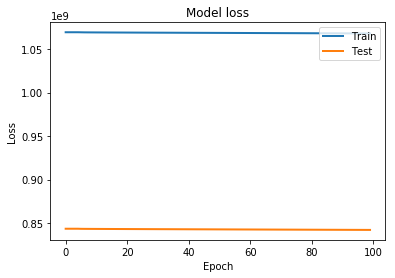

In [21]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

#Ermittlung potenzieller Kundenrisikogruppen# 
##Supervised Learning mit neuronalen Netzwerken##


In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Laden der 600000 Transaktionsdaten 
trx_data_url = 'https://raw.githubusercontent.com/sakuronohana/cas_datenanalyse/master/Semesterarbeit/Dataset/trx_data_ml.csv'

trx_data_ml = pd.read_csv(trx_data_url, delimiter=';')
trx_data_ml.head()


In [0]:
trx_data_ol.nunique()

In [0]:
trx_data.fraud_id.map(lambda x:1 if x>=1 else 0).mean()

**Erstellung des neuronalen Netzwerk-Modells**

https://www.youtube.com/watch?v=BhpvH5DuVu8&list=PLQVvvaa0QuDfKTOs3Keq_kaG2P55YRn5v&index=46



In [0]:
import tensorflow as tf

n_nodes_hl1 = 500
n_nodes_hl2 = 500
n_nodes_hl3 = 500

n_classes = 10
batch_size = 1000

x = tf.placeholder('float',[None, 784])

def neural_network_model(data):
  hidden_1_layer = {'weights':tf.Variable(tf.random_normal([784,n_nodes_hl1])),
                   'biases':tf.Variable(tf.random_normal(n_nodes_hl1))}
  hidden_2_layer = {'weights':tf.Variable(tf.random_normal([n_nodes_hl2,n_nodes_hl2])),
                   'biases':tf.Variable(tf.random_normal(n_nodes_hl2))}
  hidden_3_layer = {'weights':tf.Variable(tf.random_normal([n_nodes_hl2,n_nodes_hl3])),
                   'biases':tf.Variable(tf.random_normal(n_nodes_hl3))}
  output_layer = {'weights':tf.Variable(tf.random_normal([n_nodes_hl3,n_nodes_hl1])),
                   'biases':tf.Variable(tf.random_normal(n_classes))}
  
  l1 = tf.add(tf.matmul(data, hidden_1_layer['weights']), hidden_1_layer['biases'])
  l1 = tf.nn.relu(l1)
  
  l2 = tf.add(tf.matmul(l1, hidden_2_layer['weights']), hidden_2_layer['biases'])
  l2 = tf.nn.relu(l2)
  
  l3 = tf.add(tf.matmul(l2, hidden_3_layer['weights']), hidden_3_layer['biases'])
  l3 = tf.nn.relu(l3)
                 
  output = tf.add(l3, output_layer['weights'])+ output_layer['biases']
  
  return output
                  
def train_neural_network(x):
  prediction = neural_network_model(x)
  cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(prediction,y))
  optimizer = tf.train.AdamOptimizer().minimize(cost)
  
  hm_epochs = 10
                  
  with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    # Hier wird das Modell trainiert
    for epoch in hm_epochs:
        epoch_loss = 0
        for _ in range(int(tdo_train.train.num_examples/batch_size)):
            x = tdo_train.next_batch(batch_size)
            _, c = sess.run([optimizer, cost], feed_dict = {x: x})
            epoch_loss += c
        print('Epoch', epoch, 'completed out of', hm_epochs, 'loss:', epoch_loss)
                  
    correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct,'float'))
    print('Accuracy:', accuracy.eval({x:tdo_test}))
    
train_neural_network(x)

##Datensatz analysieren##

##Tipp: Plotting Learning Curves - Scikit !!!!

In [0]:
# Visualisierung der Nummerischen Daten in dem Datensatz
trx_data.hist(bins=50, figsize=(20,15))
plt.show()

In [0]:
# Suche nach den Korrelationen - Teil 1
corr_matrix = trx_data.corr()
print ('Korrelation zu Payment ID','\n',corr_matrix['paym_id'].sort_values(ascending=False))
print ('Korrelation zu Zahlungssumme','\n',corr_matrix['amount'].sort_values(ascending=False))
print ('Korrelation zu Kundenvertrag','\n',corr_matrix['cust_vertrag_nr'].sort_values(ascending=False))
print ('Korrelation zu Betrugsid','\n',corr_matrix['fraud_id'].sort_values(ascending=False))

In [0]:
# Bereinigung der Daten
pd.to_datetime(trx_data['timestamp'])
pd.to_datetime(trx_data['valuta_date'])
np.where(np.isnan(trx_data))

In [0]:
# Datensatz in Trainings(80%)- und Testdatenset (20%) teilen
from sklearn.model_selection import train_test_split
train_trx_data, test_trx_data = train_test_split(trx_data, test_size=0.2, random_state=42) 
train_trx_data.count(), test_trx_data.count()

In [0]:
# Dimensionsreduktion mit PCA
from sklearn.decomposition import PCA # Import der PCA Funktion von Scikit Learn
from sklearn import preprocessing # Die Preprocessing Funktion hilft uns die Daten zu skalieren bevor sie mit PCA verwendet werden.